In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pywt

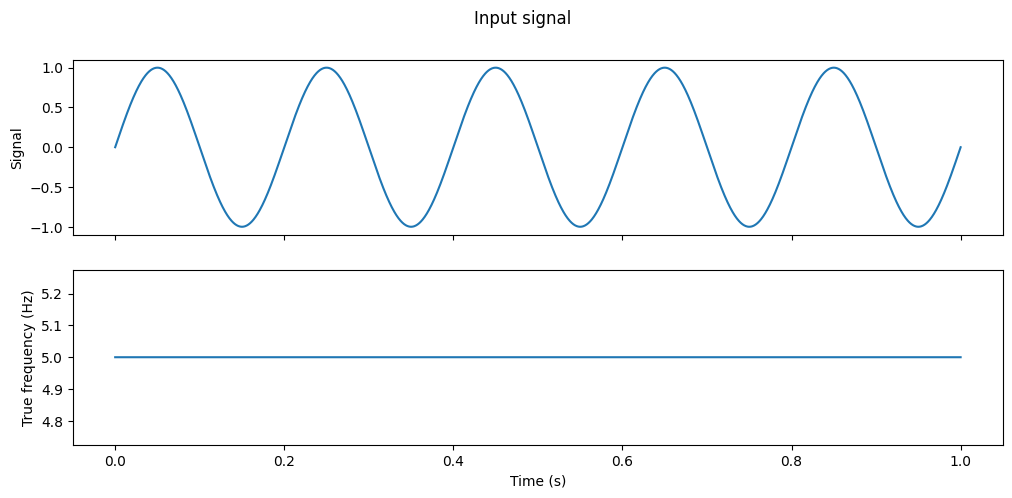

In [50]:
def gaussian(x, x0, sigma):
    return np.exp(-np.power((x - x0) / sigma, 2.0) / 2.0)


def make_chirp(t, t0, a):
    frequency = (a * (t + t0))**2
    chirp = np.sin(2 * np.pi * frequency * t)
    return chirp, frequency


# generate signal
time = np.linspace(0, 1, 2000)
signal = (np.sin(2*np.pi*time * 5))
frequency = np.ones_like(signal)*5
# plot signal
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,5))
axs[0].plot(time, signal)
axs[0].set_ylabel("Signal")
axs[1].plot(time, frequency, label="frequency1")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("True frequency (Hz)")
plt.suptitle("Input signal")
plt.show()

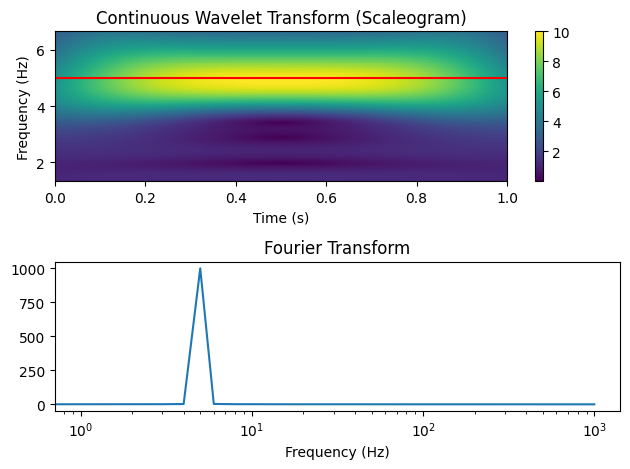

In [51]:
# perform CWT
wavelet = "cmor1.5-1.0"

# logarithmic scale for scales, as suggested by Torrence & Compo:
widths          = np.geomspace(300, 1500, num=300)
sampling_period = np.diff(time).mean()
cwtmatr, freqs  = pywt.cwt(signal, widths, wavelet, sampling_period=sampling_period)
# absolute take absolute value of complex result
cwtmatr = np.abs(cwtmatr[:-1, :-1])

# plot result using matplotlib's pcolormesh (image with annoted axes)
fig, axs = plt.subplots(2, 1)
pcm = axs[0].pcolormesh(time, freqs, cwtmatr)
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title("Continuous Wavelet Transform (Scaleogram)")
axs[0].plot(time, frequency, color="red")
fig.colorbar(pcm, ax=axs[0])

# plot fourier transform for comparison
from numpy.fft import rfft, rfftfreq

yf = rfft(signal)
xf = rfftfreq(len(signal), sampling_period)
plt.semilogx(xf, np.abs(yf))
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_title("Fourier Transform")
plt.tight_layout()